In [213]:
cfg={
    'main_folder':'/home/kvassay/data/sketch-testing/',
    'dataset_file':'dataset.npy',
    'dist_estimation_ref_obj_count': 100,
    'dist_estimation_p_vals':[1,2],
    'evaluation_set_query_obj_cnt':100,
    'evaluation_set_result_set_size':100,
    'ghp_pivot_couple_candidates': 5000,
    'ghp_pivot_selection_iteration_limit': 10000
}

In [391]:
%matplotlib inline
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yaml
from scipy.spatial.distance import minkowski, hamming
from fractions import Fraction 
from time import time
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
import pylab

In [3]:
logger = logging.getLogger()
logger.setLevel('INFO')
ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
ch.setFormatter(formatter)
# add the handlers to the logger
logger.addHandler(ch)

In [365]:
def log_pfx(obj, msg, *args):
    logger.info(obj.__class__.__name__+'| '+msg, *args)
    
def save_to(obj, file_path):
    with open(file_path, 'wb') as f:
        cPickle.dump(obj,f)

def load_from(file_path):
    with open(file_path, 'rb') as f:
        return cPickle.load(f)

def show_text(title,xlabel,ylabel):
    plt.suptitle(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
def heatmap(x,y,bins=50,figsize=(5,5),title=None, xlabel=None, ylabel=None):
    plt.figure(figsize=figsize)
    heatmap, xedges, yedges = np.histogram2d(x, y, bins)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    plt.clf()
    plt.imshow(heatmap.T, extent=extent, origin='lower')
    show_text(title,xlabel,ylabel)
    plt.show()
    
def scatter(x,y,title=None, xlabel=None, ylabel=None, point_size=5):
    plt.scatter(x, y, s=[point_size for _ in range(len(x))])
    plt.suptitle(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    
def scatter_array(arr, title=None, xlabel=None, ylabel=None, point_size=5):
    ser=pd.Series(arr)
    plt.scatter(ser.index, ser, s=[point_size for _ in range(len(arr))])
    plt.suptitle(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    
def plot_array(arr, title=None, xlabel=None, ylabel=None):
    pd.Series(arr).plot(grid=True)
    plt.suptitle(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

def hist_array(arr,bins=50, title=None, xlabel=None, ylabel=None):
    pd.Series(arr).hist(bins=bins,grid=True)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.suptitle(title)
    plt.show()
    
def restrict_2d_space(x,y,x_interval, y_interval):
    conditions=[x>=x_interval[0], x<=x_interval[1], y>=y_interval[0], y<=y_interval[1]]
    mask=conditions[0]
    for condition in conditions[1:]:
        mask=np.logical_and(mask,condition)
    return x[mask], y[mask]
    
class IterationLogger(object):
    def __init__(self, message='Started iteration no.: %s\n Time from previous iteration: %ss\n Time from start: %ss',log_by=1000):
        self.log_by=log_by
        self.num_iter=0
        self.msg=message
        self.time_started=None
        self.time_this_iter=None
        
    def next_iter(self):
        if self.time_this_iter is None:
            self.time_this_iter=time()
        if self.time_started is None:
            self.time_started=time()
        self.num_iter+=1
        if self.num_iter%self.log_by==0:
            dur_from_previous=time()-self.time_this_iter
            self.time_this_iter=time()
            dur_from_start=time()-self.time_started
            log_pfx(self, self.msg, str(self.num_iter), str(dur_from_previous), str(dur_from_start))
            

### LOAD DATA

In [5]:
dataset_path=cfg['main_folder']+cfg['dataset_file']

In [6]:
with open(dataset_path, 'rb') as f:
    decaf_vecs=np.load(f)
obj_ids=np.arange(len(decaf_vecs))

In [7]:
decaf_vecs.shape #(vectors count, vector length)

(86648, 4096)

### DATA ANALYSIS


#### Distance distribution estimation

In [190]:
def estimate_minkowski_dist_distr(vec_matrix, ref_obj_cnt, p):
    '''
    p can be either single value or list of p parameters for minkowski distance
    '''
    distances=[list() for _ in range(len(p))]
    reference_objs=vec_matrix[np.random.choice(vec_matrix.shape[0], size=ref_obj_cnt, replace=False)] #sampling without replacement
    iter_log=IterationLogger(log_by=5000)
    for decaf_vec in decaf_vecs:
        iter_log.next_iter()
        for ref_obj in reference_objs:
            for i, val_p in enumerate(p):
                dist=minkowski(ref_obj, decaf_vec, p=val_p)
                distances[i].append(dist)
    return tuple(distances)


In [9]:
dist_l1, dist_l2 = estimate_minkowski_dist_distr(decaf_vecs,  cfg['dist_estimation_ref_obj_count'], cfg['dist_estimation_p_vals'])

2017-04-11 18:13:29,345 - root - INFO - IterationLogger| Started iteration no.: 5000
 Time from previous iteration: 27.205947876s
 Time from start: 27.205947876s
2017-04-11 18:13:55,417 - root - INFO - IterationLogger| Started iteration no.: 10000
 Time from previous iteration: 26.0715830326s
 Time from start: 53.2775321007s
2017-04-11 18:14:20,295 - root - INFO - IterationLogger| Started iteration no.: 15000
 Time from previous iteration: 24.878620863s
 Time from start: 78.1561539173s
2017-04-11 18:14:45,959 - root - INFO - IterationLogger| Started iteration no.: 20000
 Time from previous iteration: 25.663642168s
 Time from start: 103.819797993s
2017-04-11 18:15:11,378 - root - INFO - IterationLogger| Started iteration no.: 25000
 Time from previous iteration: 25.4187948704s
 Time from start: 129.238593102s
2017-04-11 18:15:39,089 - root - INFO - IterationLogger| Started iteration no.: 30000
 Time from previous iteration: 27.7109408379s
 Time from start: 156.949536085s
2017-04-11 18:1

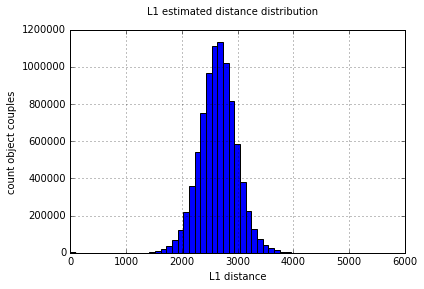

In [115]:
hist_array(dist_l1, bins=50, title='L1 estimated distance distribution',ylabel='count object couples', xlabel='L1 distance')

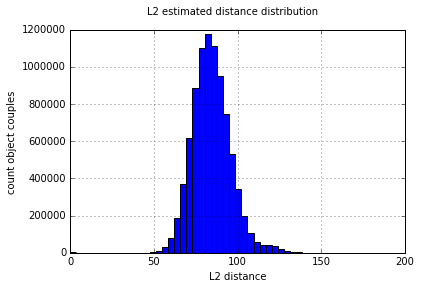

In [116]:
hist_array(dist_l2, bins=50,title='L2 estimated distance distribution',ylabel='count object couples', xlabel='L2 distance')

## Dimensionality reduction

Explained variance of 3 top components - x,y,z

In [373]:
pca.explained_variance_ratio_

array([ 0.05537615,  0.02953104,  0.02126313])

In [374]:
x,y,z=dim_2_vectors.T[0],dim_2_vectors.T[1],dim_2_vectors.T[2]

#### Components heat-map

x,y

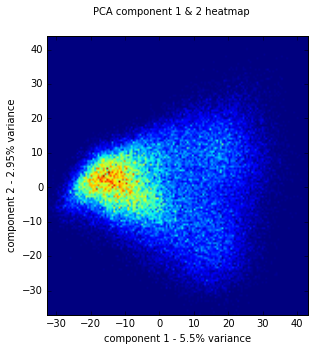

In [383]:
heatmap(x,y,bins=150,figsize=(5,5), title='PCA component 1 & 2 heatmap ',xlabel='component 1 - 5.5% variance',ylabel='component 2 - 2.95% variance')

x,z

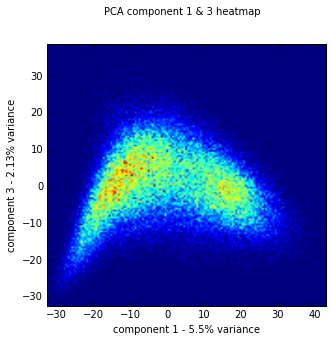

In [384]:
heatmap(x,z,bins=150,figsize=(5,5), title='PCA component 1 & 3 heatmap',xlabel='component 1 - 5.5% variance',ylabel='component 3 - 2.13% variance')

y,z

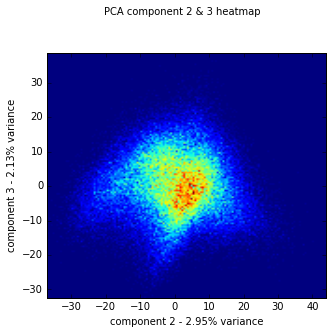

In [389]:
heatmap(y,z,bins=150,figsize=(5,5), title='PCA component 2 & 3 heatmap',xlabel='component 2 - 2.95% variance',ylabel='component 3 - 2.13% variance')

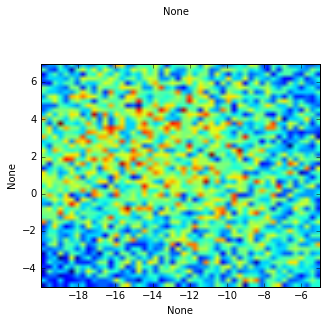

In [378]:
x_close, y_close=restrict_2d_space(x,y,[-20, -5],[-5,7])
heatmap(x_close,y_close,bins=50,figsize=(5,5))

## APPROXIMATION  EVALUATION SET
We select 100 query objects and their 100 closest object's id's from the dataset to evaluate. It simulates the scenario where almost never more than 100 objects are required for result set. 

In [12]:
eval_queries_indicies=np.random.choice(decaf_vecs.shape[0], size=cfg['evaluation_set_query_obj_cnt'], replace=False)
eval_queries_vecs=decaf_vecs[eval_queries_indicies] 
eval_queries_ids=obj_ids[eval_queries_indicies]
eval_k=cfg['evaluation_set_result_set_size'] #k for knn to evaluation objects

In [13]:
eval_result_objs=[list() for _ in range(len(eval_queries_ids))]

Finds k-NN query result

In [14]:
iter_log=IterationLogger(log_by=5000)
for i in range(len(decaf_vecs)):
    iter_log.next_iter()
    candidate_vec=decaf_vecs[i]
    candidate_id=obj_ids[i]
    for j in range(len(eval_queries_vecs)):
        query_vec=eval_queries_vecs[j]
        dist=minkowski(candidate_vec, query_vec, p=1)
        if len(eval_result_objs[j])>0:
            if dist<eval_result_objs[j][-1][1]: #if not object is not member of result set
                eval_result_objs[j].append((candidate_id, dist))
                eval_result_objs[j].sort(key=lambda x: x[1],reverse=False)
                if len(eval_result_objs[j])>eval_k:#if > k objects remove last one
                    del eval_result_objs[j][-1] 
        else:
            eval_result_objs[j].append((candidate_id, dist))
            

2017-04-11 18:20:35,782 - root - INFO - IterationLogger| Started iteration no.: 5000
 Time from previous iteration: 14.4007408619s
 Time from start: 14.4007408619s
2017-04-11 18:20:49,661 - root - INFO - IterationLogger| Started iteration no.: 10000
 Time from previous iteration: 13.8785099983s
 Time from start: 28.2792520523s
2017-04-11 18:21:02,690 - root - INFO - IterationLogger| Started iteration no.: 15000
 Time from previous iteration: 13.0295069218s
 Time from start: 41.3087599277s
2017-04-11 18:21:15,745 - root - INFO - IterationLogger| Started iteration no.: 20000
 Time from previous iteration: 13.0547690392s
 Time from start: 54.3635308743s
2017-04-11 18:21:28,686 - root - INFO - IterationLogger| Started iteration no.: 25000
 Time from previous iteration: 12.9415459633s
 Time from start: 67.3050768375s
2017-04-11 18:21:42,034 - root - INFO - IterationLogger| Started iteration no.: 30000
 Time from previous iteration: 13.3473861217s
 Time from start: 80.652463913s
2017-04-11 1

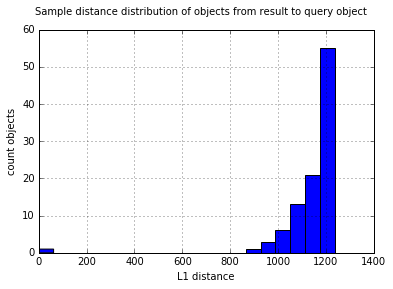

In [112]:
hist_array([obj[1] for obj in eval_result_objs[17]],bins=20,title='Sample distance distribution of objects from result to query object',xlabel='L1 distance',ylabel='count objects')

## GENERALIZED HYPERPLANE PARTITIONING PIVOTS SELECTION

In [214]:
pivot_cand_cpl_cnt=cfg['ghp_pivot_couple_candidates']
vec_iter_limit=cfg['ghp_pivot_selection_iteration_limit']

Select random pivot couples

In [215]:
cand_indicies=np.random.choice(decaf_vecs.shape[0], size=pivot_cand_cpl_cnt*2, replace=False)
pivot_cand_vecs=decaf_vecs[cand_indicies]
pivot_cand_ids=obj_ids[cand_indicies]
pivot_cand_vecs_a, pivot_cand_vecs_b=np.split(pivot_cand_vecs,2)
pivot_cand_ids_a, pivot_cand_ids_b=np.split(pivot_cand_ids,2)
pivot_cand_vecs=zip(pivot_cand_vecs_a, pivot_cand_vecs_b)
pivot_cand_ids=zip(pivot_cand_ids_a, pivot_cand_ids_b)

In [216]:
left_members_cnt=[0 for _ in range(len(pivot_cand_ids))]
sum_dist_from_ghp=[0 for _ in range(len(pivot_cand_ids))]

In [217]:
def get_ghp_partition(obj, pivot_a, pivot_b):
    '''
    returns partition 0/1 and distance to closest pivot
    '''
    dist_a=minkowski(vec, pivot_cpl_vec[0], p=1)
    dist_b=minkowski(vec, pivot_cpl_vec[1], p=1)
    if dist_a<dist_b:
        return 1, dist_a
    if dist_a>dist_b:
        return 0, dist_b
    return np.random.choice([0,1]), dist_a
    
def compute_part_balance(cnt_partition, cnt_all):
    '''
    1 - 2*|0.5-x/y| where x is count members in left or right partition and y is count all members
    '''
    return 1.0-(2*abs(0.5-(cnt_partition/cnt_all)))

def plot_balance_f():
    plot_array([compute_part_balance(float(num),float(1000)) for num in range(0,1001)], title='GHP balance function',xlabel='x| no. pivots in left partition',ylabel='b(x)')


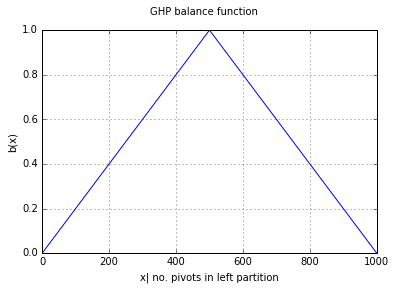

In [218]:
plot_balance_f()

Compute balances and average distance from hyperplane for pivot couples

In [219]:
iter_log=IterationLogger(log_by=1000)
for vec in decaf_vecs[:vec_iter_limit]:
    iter_log.next_iter()
    for i, pivot_cpl_vec in enumerate(pivot_cand_vecs):
        partition,dist=get_ghp_partition(vec, pivot_cpl_vec[0], pivot_cpl_vec[1])
        left_members_cnt[i]+=partition
        sum_dist_from_ghp[i]+=dist

2017-04-11 20:28:02,506 - root - INFO - IterationLogger| Started iteration no.: 1000
 Time from previous iteration: 269.709495068s
 Time from start: 269.709494114s
2017-04-11 20:32:23,441 - root - INFO - IterationLogger| Started iteration no.: 2000
 Time from previous iteration: 260.934378862s
 Time from start: 530.643873215s
2017-04-11 20:36:38,341 - root - INFO - IterationLogger| Started iteration no.: 3000
 Time from previous iteration: 254.900829077s
 Time from start: 785.544703007s
2017-04-11 20:41:03,007 - root - INFO - IterationLogger| Started iteration no.: 4000
 Time from previous iteration: 264.665160179s
 Time from start: 1050.20986319s
2017-04-11 20:45:34,650 - root - INFO - IterationLogger| Started iteration no.: 5000
 Time from previous iteration: 271.643430948s
 Time from start: 1321.85329413s
2017-04-11 20:49:59,646 - root - INFO - IterationLogger| Started iteration no.: 6000
 Time from previous iteration: 264.995672941s
 Time from start: 1586.84896803s
2017-04-11 20:54

In [220]:
balances=[compute_part_balance(float(cnt), float(vec_iter_limit)) for cnt in left_members_cnt]
avg_dist_from_hp=[float(num)/vec_iter_limit for num in sum_dist_from_ghp]
sum_avg_dist_from_hp=sum(avg_dist_from_hp)
normalized_avg_dist_from_hp=[float(dist)/float(sum_avg_dist_from_hp) for dist in avg_dist_from_hp]

In [221]:
min(balances)

0.00019999999999997797

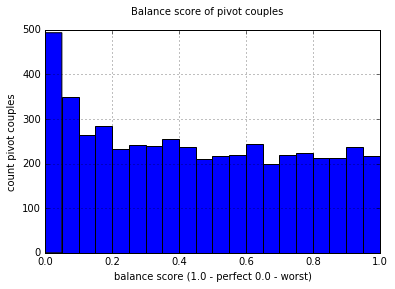

In [222]:
hist_array(sorted(balances,reverse=True),bins=20, title='Balance score of pivot couples', xlabel='balance score (1.0 - perfect 0.0 - worst)', ylabel='count pivot couples')

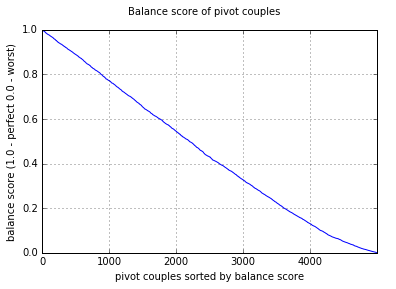

In [223]:
plot_array(sorted(balances,reverse=True),title='Balance score of pivot couples', ylabel='balance score (1.0 - perfect 0.0 - worst)', xlabel='pivot couples sorted by balance score')

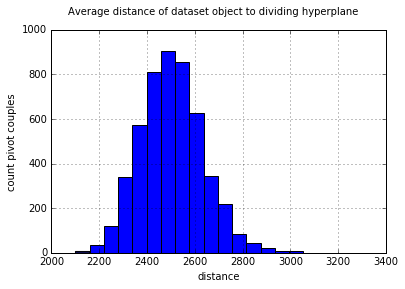

In [224]:
hist_array(sorted(avg_dist_from_hp,reverse=False),xlabel='distance', ylabel='count pivot couples',title='Average distance of dataset object to dividing hyperplane',bins=20)

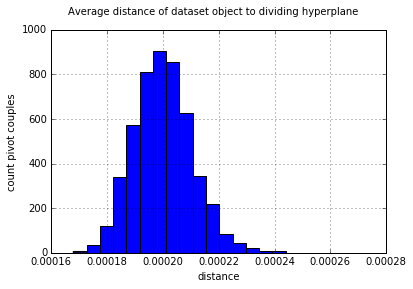

In [225]:
hist_array(sorted(normalized_avg_dist_from_hp,reverse=False),xlabel='distance', ylabel='count pivot couples',title='Average distance of dataset object to dividing hyperplane',bins=20)

In [227]:
#vybrat spravnych pivotov na zaklade biobjective function - oskorovat pivotov 0-1 na zaklade oboch kriterii a vybrat nejakych top kombinovane

In [228]:
#potom perzistnut a prejst asi na iny notebook s tymi oscorovanymi pivotmi + evaluacne data 